# Completion Rate and Abandonment Rate - Funnel Analysis
A funnel analysis shows the proportion of users who complete each step in a process, helping to identify where drop-offs occur.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from datetime import datetime

%matplotlib inline

In [15]:
# Dataset:
df = pd.read_csv('../data/clean/df_final_experiment_web_data_demo.csv', sep=',')
df.head()

,client_id,visitor_id,visit_id,process_step,date_time,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,5,64,79.0,U,2,189023.86,1,4
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,5,64,79.0,U,2,189023.86,1,4
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,5,64,79.0,U,2,189023.86,1,4
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,5,64,79.0,U,2,189023.86,1,4
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,5,64,79.0,U,2,189023.86,1,4


In [17]:
df.shape

(317235, 14)

In [19]:
# Let's prepare the succesfull case data

# Step 1: Filter for users who have completed all steps (start, step_1, step_2, step_3, confirm)
required_steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Identify sessions (visit_id) that have all the required steps
completed_sessions = df.groupby('visit_id')['process_step'].apply(lambda x: set(required_steps).issubset(set(x)))

# Filter the dataframe to only include completed sessions
df_completed = df[df['visit_id'].isin(completed_sessions[completed_sessions].index)]

In [188]:
df_completed.shape

(200657, 14)

In [21]:
# Step 2: Remove any records that occur after the user reaches the 'confirm' step
# We first find the index of the first occurrence of 'confirm' for each visit_id
df_completed['confirm_reached'] = df_completed.groupby('visit_id')['process_step'].transform(lambda x: (x == 'confirm').cumsum())

# Remove any records after 'confirm' is reached (including multiple 'confirm' rows)
df_completed = df_completed[df_completed['confirm_reached'] <= 1]

/var/folders/t_/k5bhrc1x419crrfg_t8zp5nm0000gp/T/ipykernel_18795/1862611387.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_completed['confirm_reached'] = df_completed.groupby('visit_id')['process_step'].transform(lambda x: (x == 'confirm').cumsum())


In [23]:
df_completed.shape

(183687, 15)

In [27]:
df_completed.head()

,client_id,visitor_id,visit_id,process_step,date_time,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,confirm_reached
8,8320017,39393514_33118319366,960651974_70596002104_312201,confirm,2017-04-05 13:10:05,Test,22,274,34.5,M,2,36001.9,5,8,1
9,8320017,39393514_33118319366,960651974_70596002104_312201,step_3,2017-04-05 13:09:43,Test,22,274,34.5,M,2,36001.9,5,8,1
10,8320017,39393514_33118319366,960651974_70596002104_312201,step_2,2017-04-05 13:08:40,Test,22,274,34.5,M,2,36001.9,5,8,1
11,8320017,39393514_33118319366,960651974_70596002104_312201,step_1,2017-04-05 13:08:24,Test,22,274,34.5,M,2,36001.9,5,8,1
12,8320017,39393514_33118319366,960651974_70596002104_312201,start,2017-04-05 13:08:06,Test,22,274,34.5,M,2,36001.9,5,8,1


In [25]:
# Now, let's prepare the Falied case data

# Step 1: Identify sessions (visit_id) where the user has started but never reached 'confirm'
# First, group by 'visit_id' and extract the set of steps for each session
session_steps = df.groupby('visit_id')['process_step'].apply(set)

# Step 2: Filter to get only sessions that contain 'start' but do not contain 'confirm'
incomplete_sessions = session_steps[session_steps.apply(lambda x: 'start' in x and 'confirm' not in x)]

# Step 3: Filter the original DataFrame to only include those incomplete sessions
df_incomplete = df[df['visit_id'].isin(incomplete_sessions.index)]

# Step 4: Ensure the dataset is sorted by 'visit_id' and 'date_time'
df_incomplete = df_incomplete.sort_values(by=['visit_id', 'date_time'], ascending=[True, True])

In [198]:
df_incomplete.shape

(106703, 14)

In [204]:
# Step 5: Merge df_completed and df_incomplete using pd.concat
df_combined = pd.concat([df_completed, df_incomplete], ignore_index=True)

df_combined.head()

,client_id,visitor_id,visit_id,process_step,date_time,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,confirm_reached
0,8320017,39393514_33118319366,960651974_70596002104_312201,confirm,2017-04-05 13:10:05,Test,22,274,34.5,M,2,36001.9,5,8,1.0
1,8320017,39393514_33118319366,960651974_70596002104_312201,step_3,2017-04-05 13:09:43,Test,22,274,34.5,M,2,36001.9,5,8,1.0
2,8320017,39393514_33118319366,960651974_70596002104_312201,step_2,2017-04-05 13:08:40,Test,22,274,34.5,M,2,36001.9,5,8,1.0
3,8320017,39393514_33118319366,960651974_70596002104_312201,step_1,2017-04-05 13:08:24,Test,22,274,34.5,M,2,36001.9,5,8,1.0
4,8320017,39393514_33118319366,960651974_70596002104_312201,start,2017-04-05 13:08:06,Test,22,274,34.5,M,2,36001.9,5,8,1.0


In [206]:
df_combined.shape

(290390, 15)

In [208]:
# Step 6: Calculate the funnel for both Control and Test

# Define the process steps in order
steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Funnel Analysis for Control
funnel_control = df_combined[df_combined['Variation'] == 'Control'].groupby('process_step')['visit_id'].nunique().reindex(steps).fillna(0)

# Funnel Analysis for Test
funnel_test = df_combined[df_combined['Variation'] == 'Test'].groupby('process_step')['visit_id'].nunique().reindex(steps).fillna(0)

# Step 3: Combine the results into a single DataFrame for comparison
funnel_comparison = pd.DataFrame({
    'Funnel (Control)': funnel_control,
    'Funnel (Test)': funnel_test
})

# Display the final funnel comparison
display(funnel_comparison)

,Funnel (Control),Funnel (Test)
process_step,,
start,30243,31263
step_1,22663,26141
step_2,19176,22262
step_3,17179,19726
confirm,14753,17794


In [221]:
# Now, let's calculate the proportions:

# Step 1: Calculate proportions for Control and Test
# The proportion at each step is the number of users at that step divided by the number of users who started (step 'start')

funnel_comparison['Proportion (Control)'] = funnel_comparison['Funnel (Control)'] / funnel_comparison['Funnel (Control)'].loc['start']
funnel_comparison['Proportion (Test)'] = funnel_comparison['Funnel (Test)'] / funnel_comparison['Funnel (Test)'].loc['start']

# Step 2: Display the updated funnel comparison with proportions
display(funnel_comparison)

,Funnel (Control),Funnel (Test),Proportion (Control),Proportion (Test)
process_step,,,,
start,30243,31263,1.000000,1.000000
step_1,22663,26141,0.749363,0.836164
step_2,19176,22262,0.634064,0.712088
step_3,17179,19726,0.568032,0.630970
confirm,14753,17794,0.487815,0.569171


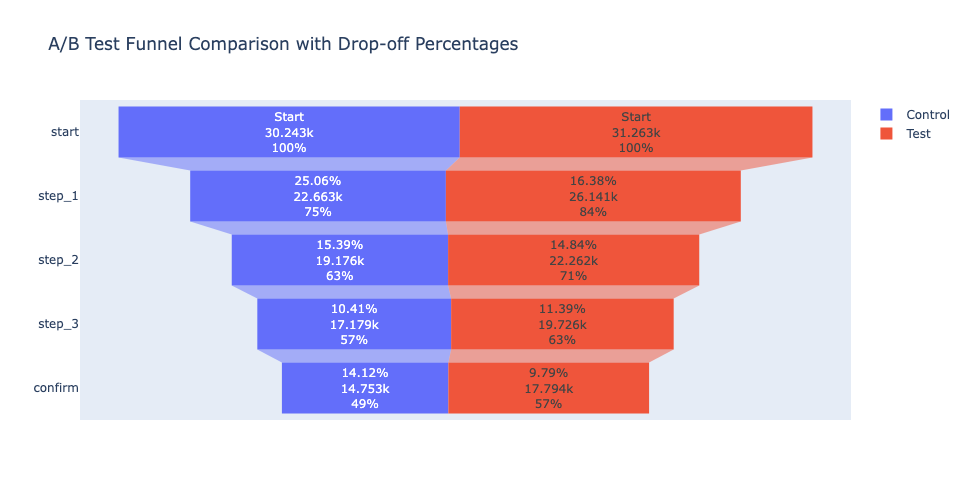

In [223]:
#  Function to calculate drop-off percentages

def calculate_dropoff_percentages(funnel):
    dropoffs = []
    for i in range(1, len(funnel)):
        dropoff = (funnel[i-1] - funnel[i]) / funnel[i-1] * 100
        dropoffs.append(f"{dropoff:.2f}%")
    dropoffs.insert(0, "Start")  # No drop-off for the first step
    return dropoffs

# Data
stages = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
control = [30243, 22663, 19176, 17179, 14753]  # Funnel A
test = [31263, 26141, 22262, 19726, 17794]    # Funnel B

# Calculate drop-off percentages
control_dropoffs = calculate_dropoff_percentages(control)
test_dropoffs = calculate_dropoff_percentages(test)

# Create the funnel chart with larger figure size
fig = go.Figure()

# Funnel A with larger drop-off percentages inside the funnel
fig.add_trace(go.Funnel(
    name='Control',
    y=stages,
    x=control,
    text=control_dropoffs,
    textinfo="text+value+percent initial",
    textposition="inside",
    textfont=dict(size=16)  # Increase font size specifically for inside funnel
))

# Funnel B with larger drop-off percentages inside the funnel
fig.add_trace(go.Funnel(
    name='Test',
    y=stages,
    x=test,
    text=test_dropoffs,
    textinfo="text+value+percent initial",
    textposition="inside",
    textfont=dict(size=16)  # Increase font size specifically for inside funnel
))

# Increase the size of the figure to allow more space for text
fig.update_layout(
    title="A/B Test Funnel Comparison with Drop-off Percentages",
    height=500,  # Increase height to make more room
    width=900   # Increase width if necessary
)

fig.show()